In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import shutil
shutil.copyfile('/content/drive/MyDrive/annotation.zip', '/content/annotation.zip') 
shutil.copyfile('/content/drive/MyDrive/image.zip', '/content/image.zip') 

'/content/image.zip'

In [ ]:
!unzip annotation.zip
!unzip image.zip

In [ ]:
import tensorflow as tf
import cv2
import os
import scipy
import numpy as np

train_dir = '/content/image/'

#train_dir = '/content/drive/MyDrive/data_road/training/image_2/'
# os.path.join("/content","drive", "live", "training", "image_2")+"/"   # os.path.join是做连接符，等同于data/train/img

#train_label_dir = '/content/drive/MyDrive/data_road/training/gt_image_2/'
train_label_dir = '/content/annotation/'
# os.path.join("/content","drive", "data_road", "training", "gt_image_2")+"/"

train_list_dir = os.listdir(train_dir)  # 列出train-image目录下的图片名字, 形如["um_000001.png", ...]
train_list_dir.sort()  # sort是排序，使得train_list与train_label_list一一对应

train_label_list_dir = os.listdir(train_label_dir)  # 列出train-label目录下的图片名字,形如["um_road_000001.png", ...]
train_label_list_dir.sort()

assert len(train_list_dir)==len(train_label_list_dir), "训练的图片与标签数量不一致"

train_filenames = [train_dir + filename for filename in train_list_dir if filename[-3:] == 'png']  # 生成图片路径，形如["data/train/img/um_000001.png"]
train_label_filenames = [train_label_dir +
                         filename for filename in train_label_list_dir if filename[-3:] == 'png'] # 生成label路径，形如["data/train/img/um_road_000001.png"]



In [ ]:
def train_generator():
    """训练集生成器"""
    # 对之前生成的路径列表用zip打包，生成形如[("data/train/img/um_000001.png", "data/train/img/um_road_000001.png"), ....]的列表，然后遍历列表，取出一一对应的图片与label。
    for train_file_name, train_label_filename in zip(train_filenames, train_label_filenames):
        image, label = handle_data(train_file_name, train_label_filename)
        
		# 这里第一次取的image, label = "data/train/img/um_000001.png", "data/train/img/um_road_000001.png"， 第二次往后迭代。用yield返回，这是python的generator的用法
        yield image, label

def test_generator():
    """测试集生成器"""
    for test_filename in test_filenames:
        image = handle_data(test_filename)

        yield image


def handle_data(train_filenames, train_label_filenames=None):
    """对数据做处理"""
    image = cv2.imread(train_filenames)
    image = cv2.resize(image, image_shape[::-1])# 因为数据的size都不一样，所以需要统一resize到我们约定的size（160，576）
    
    # 对影像的处理，去除阴影，这一步可以不做，只是效果会差一些。
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
    image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    
    # 对label做处理
    if train_label_filenames is not None:
        gt_image = cv2.imread(train_label_filenames)
        gt_image = cv2.resize(gt_image, image_shape[::-1])

        background_color = np.array([255, 0, 0])
        gt_bg = np.all(gt_image == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
    
        return np.array(image), gt_image
    else:
        return np.array(image)



# def handle_data(train_filenames, train_label_filenames=None):
#     """对数据做处理"""
#     image = scipy.misc.imresize(
#         scipy.misc.imread(train_filenames), image_shape)  # 因为数据的size都不一样，所以需要统一resize到我们约定的size（160，576）
    
#     # 对影像的处理，去除阴影，这一步可以不做，只是效果会差一些。
#     image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#     image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
#     image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

# 	对label做处理
#     if train_label_filenames is not None:
#         gt_image = scipy.misc.imresize(
#             scipy.misc.imread(train_label_filenames), image_shape)
        
#         background_color = np.array([255, 0, 0])
#         gt_bg = np.all(gt_image == background_color, axis=2)
#         gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
#         gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
    
#         return np.array(image), gt_image
#     else:
#         return np.array(image)





In [ ]:
import matplotlib.pyplot as plt
image = cv2.imread(train_filenames[0])
image_shape = (160, 576)
image = cv2.resize(image, image_shape[::-1])# 因为数据的size都不一样，所以需要统一resize到我们约定的size（160，576）

gt_image = cv2.imread(train_label_filenames[0])
gt_image = cv2.resize(gt_image, image_shape[::-1])

background_color = np.array([255, 0, 0])
gt_bg = np.all(gt_image == background_color, axis=2)
gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
# print(np.array(image))
Result = handle_data(train_filenames[0], train_label_filenames[0])

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32), (tf.TensorShape([None, None, None]), tf.TensorShape([None, None, None])))

train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))  # 打乱数据的顺序，即不按照之前sort的顺序读取
train_dataset = train_dataset.batch(5)  # 设置批量，同时训练的数据量。tensorflow模型的输入维度为[batcn, h, w, c]



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Input

# 加载模型，参数分别表示
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(160, 160, 3)))

vgg16_model.summary()  # 这一行是为了打印模型结构

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                              

In [ ]:
# model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.initializers import Constant
# from tensorflow.nn import conv2d_transpose

def bilinear_upsample_weights(factor, number_of_classes):
    """初始化权重参数"""
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights
  

class MyModel(tf.keras.Model):
    def __init__(self, n_class):
        super().__init__()
        self.vgg16_model = self.load_vgg()
        
        self.conv_test = Conv2D(filters=n_class, kernel_size=(1, 1))  # 分类层
        self.deconv_test = Conv2DTranspose(filters=n_class, 
                        kernel_size=(64, 64),
                        strides=(32, 32),
                        padding='same',
                        activation='sigmoid',
                        kernel_initializer=Constant(bilinear_upsample_weights(32, n_class)))  # 上采样层

    def call(self, input):
      x = self.vgg16_model(input)
      x = self.conv_test(x)
      x = self.deconv_test(x)
      return x

    def load_vgg(self):
        # 加载vgg16模型，其中注意input_tensor，include_top
        vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_shape[0], image_shape[1], 3)))
        for layer in vgg16_model.layers[:15]:
          layer.trainable = False  # 不训练前15层模型
        return vgg16_model


In [ ]:
import os
import tensorflow as tf
import numpy as np
import scipy
import cv2
from skimage import io

train_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32), (tf.TensorShape([None, None, None]), tf.TensorShape([None, None, None])))

train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))
train_dataset = train_dataset.batch(10)

#model = MyModel(2)  # FCN模型
model = DeepLabV3Plus(image_shape[0], image_shape[1], nclasses=2)  # deeplab模型

# 在得到模型后，配置compile的参数即可，需要optimizer与loss与评估器。learning_rate一般取0.001或者0.0001较好。
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.compat.v2.nn.softmax_cross_entropy_with_logits,
    metrics=['accuracy']
)

# fit输入的参数为训练集dataset以及跑的轮数，可自己配置，用colab的gpu跑100轮需要1个小时左右。
model.fit(train_dataset, epochs=1)
# model.summary()

# 保存模型，以便以后在这个模型的基础上训练，或者用这个模型测试时，只需要这一个文件与测试数据集即可，不需要再定义模型。
# model.save('weights/fcn8s_20191021.h5')



In [ ]:
# import os
# import tensorflow as tf
# import numpy as np
# import scipy
# import cv2
# from skimage import io

# num_epochs = 5
# train_dataset = tf.data.Dataset.from_generator(
#     train_generator, (tf.float32, tf.float32), (tf.TensorShape([None, None, None]), tf.TensorShape([None, None, None])))

# train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))
# train_dataset = train_dataset.batch(2)

# model = MyModel(2)  # FCN模型

# # os.chdir('/content/drive/data_road/weights')
# # model = MyModel(2)
# # model.build(input_shape = [None,160,576,3])
# # model.load_weights('FCN8S_20211126.h5')
# # model = DeepLabV3Plus(image_shape[0], image_shape[1], nclasses=2)  # deeplab模型
# # model.load_weights('DEEPV3_20211126.h5')

# # 在得到模型后，配置compile的参数即可，需要optimizer与loss与评估器。learning_rate一般取0.001或者0.0001较好。
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(
#     optimizer=optimizer,
#     loss=tf.compat.v2.nn.softmax_cross_entropy_with_logits,
#     metrics=['accuracy']
# )
# # fit输入的参数为训练集dataset以及跑的轮数，可自己配置，用colab的gpu跑100轮需要1个小时左右。
# model.fit(train_dataset, num_epochs)
# # model.summary()

# # # 保存模型，以便以后在这个模型的基础上训练，或者用这个模型测试时，只需要这一个文件与测试数据集即可，不需要再定义模型。
# # model.save('weights/FCN8S_20211126.h5')



In [ ]:
os.chdir('/content/drive/data_road/')
model.save_weights('weights/DEEPV3_20211127.h5')

In [ ]:
#model = MyModel(2)
model = DeepLabV3Plus(image_shape[0], image_shape[1], nclasses=2)  # deeplab模型
os.chdir('/content/drive/MyDrive/Cell')
model.build([None, 160, 576, 3])
model.load_weights('DeepLabV3.h5')

*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 160, 576, 2) ***


In [ ]:
import matplotlib.pyplot as plt

filename = train_filenames[0]
#filename = test_filenames[0]
img = cv2.imread(filename)
ori_image = cv2.resize(img, image_shape[::-1])
image = ori_image[np.newaxis,:,:,:].astype("float32")
print(image.shape)
result = model.predict(image)
r = result[0]
Re = r[:,:,0]
print(Re.shape)
r
# plt.imshow(Re)
# result = model.predict(img)

(160, 576, 3)


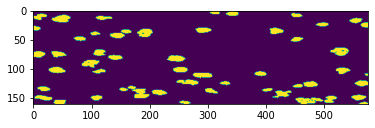

In [ ]:
filename = train_label_filenames[0]
img = cv2.imread(filename)
img = cv2.resize(img, image_shape[::-1])
print(img.shape)
plt.imshow(img[:,:,0])

In [ ]:
# Model 2
# model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Add, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.initializers import Constant
# from tensorflow.nn import conv2d_transpose
image_shape = (160, 576)
def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights
  

class MyModel(tf.keras.Model):
    def __init__(self, NUM_OF_CLASSESS):
        super().__init__()
        vgg16_model = self.load_vgg()
        self.conv1_1 = vgg16_model.layers[1]
        self.conv1_2 = vgg16_model.layers[2]
        self.pool1 = vgg16_model.layers[3]
        #(128,128)
        self.conv2_1 = vgg16_model.layers[4]
        self.conv2_2 = vgg16_model.layers[5]
        self.pool2 = vgg16_model.layers[6]
        #(64,64)
        self.conv3_1 = vgg16_model.layers[7]
        self.conv3_2 = vgg16_model.layers[8]
        self.conv3_3 = vgg16_model.layers[9]
        self.pool3 =  vgg16_model.layers[10]
        #(32,32)
        self.conv4_1 = vgg16_model.layers[11]
        self.conv4_2 = vgg16_model.layers[12]
        self.conv4_3 = vgg16_model.layers[13]
        self.pool4 =  vgg16_model.layers[14]
        #(16,16)
        self.conv5_1 = vgg16_model.layers[15]
        self.conv5_2 =  vgg16_model.layers[16]
        self.conv5_3 = vgg16_model.layers[17]
        self.pool5 = vgg16_model.layers[18]
        self.conv6 = Conv2D(4096,(7,7),(1,1),padding="same",activation="relu")
        self.drop6 = Dropout(0.5)
        self.conv7 = Conv2D(4096,(1,1),(1,1),padding="same",activation="relu")
        self.drop7 = Dropout(0.5)
        self.score_fr = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.score_pool4 = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.conv_t1 = Conv2DTranspose(NUM_OF_CLASSESS,(4,4),(2,2),padding="same")
        self.fuse_1 = Add()
        self.conv_t2 = Conv2DTranspose(NUM_OF_CLASSESS,(4,4),(2,2),padding="same")
        self.score_pool3 = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.fuse_2 = Add()
        self.conv_t3 = Conv2DTranspose(NUM_OF_CLASSESS,(16,16),(8,8),padding="same", activation="sigmoid", kernel_initializer=Constant(bilinear_upsample_weights(8, NUM_OF_CLASSESS)))
        

    def call(self, input):
      x = self.conv1_1(input)
      x = self.conv1_2(x)
      x = self.pool1(x)
      x = self.conv2_1(x)
      x = self.conv2_2(x)
      x = self.pool2(x)
      x = self.conv3_1(x)
      x = self.conv3_2(x)
      x = self.conv3_3(x)
      x_3 = self.pool3(x)
      x = self.conv4_1(x_3)
      x = self.conv4_2(x)
      x = self.conv4_3(x)
      x_4 = self.pool4(x)
      x = self.conv5_1(x_4)
      x = self.conv5_2(x)
      x = self.conv5_3(x)
      x = self.pool5(x)
      x = self.conv6(x)
      x = self.drop6(x)
      x = self.conv7(x)
      x = self.drop7(x)
      x = self.score_fr(x)  # 第5层pool分类结果
      x_score4 = self.score_pool4(x_4) # 第4层pool分类结果
      x_dconv1 = self.conv_t1(x)  # 第5层pool分类结果上采样
      x = self.fuse_1([x_dconv1,x_score4])  # 第4层pool分类结果+第5层pool分类结果上采样
      x_dconv2 = self.conv_t2(x)  # 第一次融合后上采样
      x_score3 = self.score_pool3(x_3)  # 第三次pool分类
      x = self.fuse_2([x_dconv2,x_score3])  #  第一次融合后上采样+第三次pool分类
      x = self.conv_t3(x)  # 上采样
      return x

    def load_vgg(self):
        # 加载vgg16模型，其中注意input_tensor，include_top
        vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_shape[0], image_shape[1], 3)))
        for layer in vgg16_model.layers[:18]:
          layer.trainable = False
        return vgg16_model



In [ ]:
#DeepLabLab V3
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Lambda, Conv2D, Conv2DTranspose, Activation, Reshape, concatenate, Concatenate, BatchNormalization, ZeroPadding2D

from tensorflow.keras.applications import ResNet50


def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = Lambda(lambda x: bilinear_upsample(x, size),
               output_shape=size, name=name)(tensor)
    return y


def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)

    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y


def DeepLabV3Plus(img_height, img_width, nclasses=2):
    print('*** Building DeepLabv3Plus Network ***')
    
	# 这里加载ResNet50模型，并且使用其两个模块的结果。
    base_model = ResNet50(input_shape=(
        img_height, img_width, 3), weights='imagenet', include_top=False)
    
    # 可以像模型加载章节的加载部分打印ResNet50模型，查看结构，“conv4_block6_2_relu”为层的名字， 加上.output表示这一层的输出。
    image_features = base_model.get_layer('conv4_block6_2_relu').output
    x_a = ASPP(image_features)
    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])

    x_b = base_model.get_layer('conv2_block3_2_relu').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same',
                 kernel_initializer='he_normal', name='low_level_projection', use_bias=False)(x_b)
    x_b = BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = Activation('relu', name='low_level_activation')(x_b)

    x = concatenate([x_a, x_b], name='decoder_concat')

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_1', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_1')(x)
    x = Activation('relu', name='activation_decoder_1')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_2', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_2')(x)
    x = Activation('relu', name='activation_decoder_2')(x)
    x = Upsample(x, [img_height, img_width])

    x = Conv2D(nclasses, (1, 1), name='output_layer')(x)
    '''
    x = Activation('softmax')(x) 
    tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    Args:
        from_logits: Whether `y_pred` is expected to be a logits tensor. By default,
        we assume that `y_pred` encodes a probability distribution.
    '''     
    model = Model(inputs=base_model.input, outputs=x, name='DeepLabV3_Plus')
    print(f'*** Output_Shape => {model.output_shape} ***')
    return model